In [17]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


## Formulating a linear regression model

In the previous checkpoint, we saw that linear regression models plot a line of best fit representing the relationship between the features and the target. To be more precise, a linear regression model can be formulated mathematically like this:

$$ y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon \qquad(eq.1)$$

In (eq.1), $y$ represents the target variable and $x_1, x_2,..., x_n$s represent the features. $n$ denotes the number of features. The unknowns of the equation above are the $\beta$ terms. $ \beta_0 $ refers to the **intercept** (also known as **bias** or **constant**). All the others ($\beta_1, \beta_2,...,\beta_n$) are called the **coefficients**. The $\epsilon$ is the **error term** (also known as **residual**), which represents the information in $y$ that is unexplained by the features.

**A note on terminology:** In linear regression models, it's common to refer to features in a model as __explanatory variables__ or __independent variables__ and the target variable as the __explained__ or __dependent variable__. Don't be surprised if you stumble upon these alternative terms in other places. 

The expression above can be written in a more compact form using the summation ( $\sum$ ) operator as follows:

$$ y = \beta_0 + \sum_{i=1}^{n}\beta_ix_i + \epsilon \qquad(eq.2)$$


In (eq.2), $\sum_{i=1}^{n}$ adds up each $\beta_ix_i$ where the subscript $i$ refers to the index of the features and the coefficients. Hence $\sum_{i=1}^{n}$ starts from $i=1$ and goes until $i=n$.


## Insurance charges dataset

Throughout this module, we'll demonstrate linear regression modeling on a medical cost dataset originally from Kaggle. The original dataset is called "Medical Cost Personal Dataset" and can be found at this [link](https://www.kaggle.com/mirichoi0218/insurance). We'll be working with a SQL-based version of this dataset hosted on a Postgres server, but if you want full documentation on the data, refer to the Kaggle link.

The data is about the costs charged by the insurance companies to individuals. These are costs that the insured individuals were required to pay after the insurance company made payments to medical providers. The dataset includes six variables as described below:

* age: The age of the individual. It's a numeric.
* sex: The biological sex of the insured. It is categorical (male or female).
* bmi: Body mass index. This index indicates whether an individual's weight is relatively high or low, based on height. This index defines an ideal range between 18.5 and 24.9. The variable is continuous.
* children: How many dependent children the insured person has. Dependents are covered by the insurance plan. This is a numeric variable.
* smoker: This categorical variable (yes | no) indicates whether or not the person smokes.
* region: The person's residential area in the US. It's a categorical variable (northeast, southeast, southwest, northwest). 
* charges: The medical costs (in US dollars) billed by the insurance company. It's a continuous variable.

In the examples, our target variable will be the "charges" billed by the insurance company. Since it's a continuous variable, we're dealing with a regression task.

In [158]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medicalcosts'

In [159]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
insurance_df = pd.read_sql_query('select * from medicalcosts',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.90
1,18,male,33.770,1,no,southeast,1725.55
2,28,male,33.000,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.50
4,32,male,28.880,0,no,northwest,3866.86
5,31,female,25.740,0,no,southeast,3756.62
6,46,female,33.440,1,no,southeast,8240.59
7,37,female,27.740,3,no,northwest,7281.51
8,37,male,29.830,2,no,northeast,6406.41
9,60,female,25.840,0,no,northwest,28923.10


First, let's look at the distribution of our target variable: charges. Investigating how our target is distributed helps us understand the relationship between the target and the features. It's also useful to discover some potential problems with our model as we'll discuss in the next checkpoint:

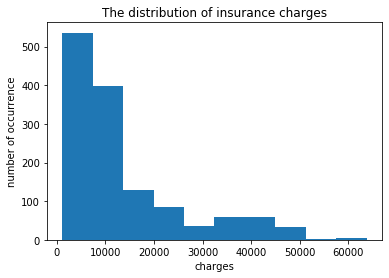

In [160]:
plt.hist(insurance_df.charges)
plt.title("The distribution of insurance charges")
plt.xlabel("charges")
plt.ylabel("number of occurrence")
plt.show()

We observe that charges is not normally distributed. Instead, it's highly skewed. **Skewness** is a measure of how asymmetric our data is with respect to the normal distribution. As we see in the graph, the charges variable is not symmetric but skewed to the right. The majority of the observations have low charges values and few of the observations have high charges values. This makes the distribution of the charges clustered at the left-most part of the histogram.

Notice that the categorical variables are strings and we need to convert them to numerical values. This can be viewed as part of the feature engineering process. One of the most convenient ways of converting categorical variables into numerical ones is called **one hot encoding**. In one hot encoding, we create a separate binary variable which takes 0 or 1 for each of the unique values of the categorical variable. Pandas' `get_dummies()` function does this job for us. 

Below, we call the `get_dummies()` function for the *sex* and *smoker* categorical variables in our dataset. Since both *sex* and *smoker* variables include two values, the `get_dummies()` function will create two dummy (indicator) variables for us. Since one of them is enough for us to indicate whether the person is male or not and is a smoker or not, we keep only one of the newly created dummies bot for *sex* and *smoker* in our data frame. We do this by feeding the parameter `drop_first`, which is set to `True` into the `get_dummies()` function.

In [161]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex, drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker, drop_first=True)

At first glance, gender and smoking may play an important role in the insurance charges. So, let's look at whether we see some differences between the average costs billed to different genders and to the ones who smoke:

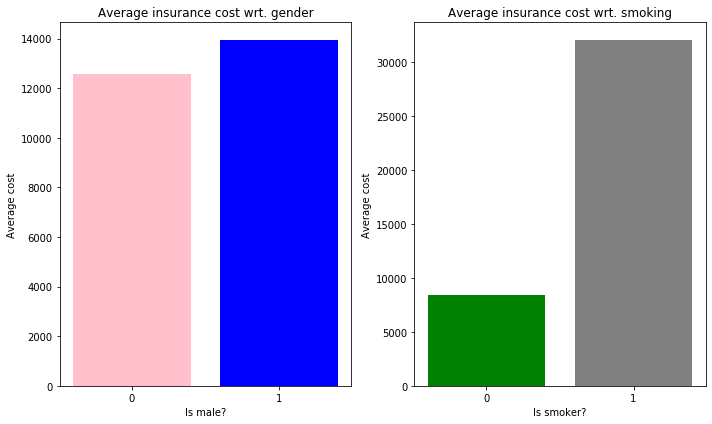

In [162]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.bar(insurance_df.groupby("is_male")["charges"].mean().index, insurance_df.groupby("is_male")["charges"].mean(),
       color=("pink","blue"))
plt.title("Average insurance cost wrt. gender")
plt.ylabel("Average cost")
plt.xlabel("Is male?")
plt.xticks([0,1])

plt.subplot(1,2,2)
plt.bar(insurance_df.groupby("is_smoker")["charges"].mean().index, insurance_df.groupby("is_smoker")["charges"].mean(),
       color=("green","grey"))
plt.title("Average insurance cost wrt. smoking")
plt.ylabel("Average cost")
plt.xlabel("Is smoker?")
plt.xticks([0,1])

plt.tight_layout()
plt.show()

As can be seen in the graph, the average costs seem to be different between each group. That is to say, on average, males seem to be charged more than females and smokers are charged more than non-smokers. 

Now, let's build our first model using these two features.

## Modeling the insurance charges with linear regression

Let's illustrate how we can model the insurance cost using a simple linear regression model. Our target variable is "charges" and we include two categorical variables as our features: "is_male" and "is_smoker". Hence, our model becomes: 

$$ charges = \beta_0 + \beta_1is\_smoker + \beta_2is\_male + \epsilon \qquad(eq.3)$$

$\beta_0$ is the constant and $\beta_1$ and $\beta_2$ are the coefficients of the is_smoker and is_male dummies respectively. 

**An important remark on the bias term**: Putting a constant in a model is optional, but it's a good idea to include a constant in every model you build. Even though you believe that the constant would be zero, letting OLS decide whether it is zero or not is the safest way.

## How to find the optimal values for coefficients?

Formulating a model is the first step in a regression problem. But, we need to find a way to discover the optimal values for the unknowns (the coefficients) in the equation above. Recall that the process of finding the optimal values of the unknowns is called **optimization**.  Here,  we need an optimization algorithm to solve for the optimal coefficient values. 

The most common optimization algorithm used in the linear regression models is called **Ordinary Least Squares** or **OLS**.

## The machinery of OLS

OLS tries to minimize the squared sums of the error terms ($\epsilon$) in the model. We can write the error term as follows:

$$(y - \beta_0 - \sum_{i=1}^{n}\beta_ix_i ) = \epsilon \qquad(eq.4)$$

If we take the square of each side, it becomes:

$$(y - \beta_0 - \sum_{i=1}^{n}\beta_ix_i )^2 = \epsilon^2 \qquad(eq.5)$$

Notice that this error term is for a single observation. If we have, say, $m$ observations in our dataset, then the sum of the squared errors can be represented like this:

$$\sum_{j=1}^{m}(y_j - \beta_0 - \sum_{i=1}^{n}\beta_ix_{ij} )^2 = \sum_{j=1}^{m}\epsilon_j^2 \qquad(eq.6)$$

Recall that $i$ was representing the index of the features in the model. In the equation above, $j$ represents the index of the observations. Hence, we go over each observation and add up their squared error terms. However, using matrix notation simplifies the expression:

$$(Y - \beta X)^2 = \mathcal{E}^2 \qquad(eq.7)$$

We will not go deeper into the derivation of the coefficients, but all you need to do is to take the derivative of  both sides with respect to each coefficient and equate them to zero! If you solve the resulting equations, then you end up with the optimal values of the coefficients:

$$ \hat{\beta} = (X^TX)^{-1}X^TY \qquad(eq.8)$$

In (eq.8), $\hat{\beta}$ indicates the estimated coefficients vector, $X^T$ refers to the transpose of the feature matrix (X), and superscript $^{-1}$ refers to the inverse of a matrix.

That's it! If you want to learn more about the derivation steps, you can read the [Wikipedia article](https://en.wikipedia.org/wiki/Ordinary_least_squares).


## An initial model for insurance charges

Using (eq.3) above, now we build a simple linear regression model and estimate it using OLS. So far in the bootcamp, we mainly used scikit-learn as our machine learning package. Here, we want to introduce another popular library for regression analysis called **statsmodels**. You may find using statsmodels for fitting linear regression models easier because it's `summary()` function outputs many important metrics in a tabular form. Getting the same metrics in scikit-learn requires more work.

But first, let's demonstrate how we fit linear regression models in scikit-learn. We'll use `LinearRegression()` model from the `linear_model` module:## An initial model for insurance charges

Using (eq.3) above, now we build a simple linear regression model and estimate it using OLS. So far in the bootcamp, we mainly used scikit-learn as our machine learning package. Here, we want to introduce another popular library for regression analysis called **statsmodels**. You may find using statsmodels for fitting linear regression models easier because it's `summary()` function outputs many important metrics in a tabular form. Getting the same metrics in scikit-learn requires more work.

But first, let's demonstrate how we fit linear regression models in scikit-learn. We'll use `LinearRegression()` model from the `linear_model` module:

In [163]:
# Y is the target variable
Y = insurance_df['charges']
# X is the feature set which includes
# is_male and is_smoker variables
X = insurance_df[['is_male','is_smoker']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [  -65.37868556 23622.13598049]

Intercept: 
 8466.03559251245


`LinearRegression()`'s `fit()` method runs the OLS algorithm by default. Since we get the parameters using OLS, we can write our estimated model:

$$ charges = 8466.04 + -65.38is\_male + 23622.14is\_smoker \qquad(eq.9)$$

According to the estimation results, the constant term is 8466.04. The estimated coefficients of the is_male and is_smoker features are -65.38 and 23622.14, respectively. Later in this module, we'll delve into how to interpret these estimated coefficients.

Now, we run the same model, this time using statsmodels. If you didn't install it already, you can run `pip install statsmodels` from the command line. 

In [164]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1088.
Date:                Tue, 29 Oct 2019   Prob (F-statistic):          4.78e-281
Time:                        19:48:36   Log-Likelihood:                -13831.
No. Observations:                1338   AIC:                         2.767e+04
Df Residuals:                    1335   BIC:                         2.768e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8466.0356    303.541     27.891      0.000    7870.566    9061.506
is_male      -65.3787    409.809     -0.160      0.873    -869.318     738.561
is_smoker   2.362e+04    507.736     46.524      0.000    2.26e+04    2.46e+04
==============================================================================
Omnibus:                      135.842   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.897
Skew:                           0.727   Prob(JB):                     9.71e-47
Kurtosis:                       4.299   Cond. No.                         2.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

First, notice that we added a constant to our existing feature set using this code:X = sm.add_constant(X). This is because statsmodels' fit() function doesn't add a constant by default as opposed to scikit-learn's fit() function.

Second, when we call the summary() function on the fitted OLS model, it prints out a table statistics. For example, in the upper side of the table, we see statistics like R-squared, adjusted R-squared, F-statistic, Log-likelihood, AIC, and BIC. Those are related to the goodness of fit of our model. In the lower part, we see statistics like Durbin-Watson, Jarque-Bera, skewness, and kurtosis. Those statistics are related to whether our model satisfies some assumptions of the linear regression model. For example, skewness is a measure of how asymmetric our data is and kurtosis is a measure of whether our data is heavy or light tailed with respect to a normal distribution. Don't worry about the details of these statistics as we'll go over some of them later in this module. For now, notice that in the middle of the table, estimated values for the coefficients are given, and those are exactly the same as what we got from the scikit-learn.

In [165]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

print(houseprices.columns)
pd.set_option('display.max_columns', None)
houseprices.head(10)

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA

In [166]:
houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

## Data Cleaning

Most of the columns are completely filled which is great. There are a couple missing the majority of values, but they would be very difficult to fill so I think I'll drop those columns(alley, fireplacequ, fence, miscfeature, poolqc). I've used the mean for lotfrontage to fill missing values, but I'm not comfortable filling missing values in the garage categories. Because less than 6% of the data is missing in these columns, I'm comfortable continuing without it.

In [167]:
houseprices["lotfrontage"].fillna(houseprices["lotfrontage"].mean(), inplace=True)

houseprices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [168]:
pd.set_option('display.max_columns', None)
houseprices.corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,1.000000,0.011156,-0.009601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
mssubclass,0.011156,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
lotfrontage,-0.009601,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.179700,0.215828,0.043340,0.122156,0.363358,0.414266,0.072483,0.036849,0.368392,0.091481,-0.006419,0.180424,0.048258,0.237023,-0.005805,0.320146,0.235755,0.066463,0.269729,0.323663,0.077106,0.137454,0.009790,0.062335,0.037684,0.180868,0.001168,0.010158,0.006768,0.334901
lotarea,-0.033226,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
overallqual,-0.028365,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
overallcond,0.012609,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
yearbuilt,-0.012713,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
yearremodadd,-0.021998,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
masvnrarea,-0.050298,0.022936,0.179700,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
bsmtfinsf1,-0.005024,-0.069836,0.215828,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303

## Correlation Matrix

Looking at the correlation matrix, there are quite a few variables that have strong and positive correlations with saleprice. Variables overallqual, totalbsmtsf, firstflrsf, grlivarea, garagecars, and garagearea have correlations greater than 0.6 with saleprice. I've chosen a number of categorical variables to make dummies with to see if there's any correlation.

In [169]:
houseprices["paved_street"] = pd.get_dummies(houseprices.street, drop_first=True)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["neighborhood"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["bldgtype"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["housestyle"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["heatingqc"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["centralair"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["kitchenqual"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["functional"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["garagetype"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["paveddrive"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["poolqc"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["fence"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["salecondition"])], axis=1)


# houseprices["heatingqc_dum"] = pd.get_dummies(houseprices.heatingqc, drop_first=True)
# houseprices["kitchenqual_dum"] = pd.get_dummies(houseprices.kitchenqual, drop_first=True)
# houseprices["functional_dum"] = pd.get_dummies(houseprices.functional, drop_first=True)
# houseprices["garagetype_dum"] = pd.get_dummies(houseprices.garagetype, drop_first=True)
# houseprices["paveddrive_dum"] = pd.get_dummies(houseprices.paveddrive, drop_first=True)
# houseprices["poolqc_dum"] = pd.get_dummies(houseprices.poolqc, drop_first=True)
# houseprices["fence_dum"] = pd.get_dummies(houseprices.fence, drop_first=True)
# houseprices["salecondition_dum"] = pd.get_dummies(houseprices.salecondition, drop_first=True)

In [170]:
dummies = houseprices.iloc[:, 80:]
pd.set_option('display.max_columns', None)

kitchen_qual = pd.concat([houseprices, pd.get_dummies(houseprices["kitchenqual"])], axis=1)
heatingqc = pd.concat([houseprices, pd.get_dummies(houseprices["heatingqc"])], axis=1)
dummies.corr()



,saleprice,paved_street,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,1Fam,2fmCon,Duplex,Twnhs,TwnhsE,1.5Fin,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,N,Y,Ex,Fa,Gd,TA,Maj1,Maj2,Min1,Min2,Mod,Sev,Typ,2Types,Attchd,Basment,BuiltIn,CarPort,Detchd,N,P,Y,Ex,Fa,Gd,GdPrv,GdWo,MnPrv,MnWw,Abnorml,AdjLand,Alloca,Family,Normal,Partial
saleprice,1.000000,0.041036,0.019066,-0.020250,-0.101303,-0.143648,0.055718,0.072626,0.071160,-0.179949,0.035940,-0.164056,-0.112544,-0.057845,-0.188513,-0.037910,0.023483,0.330424,0.402149,-0.192189,-0.063705,-0.128394,0.014560,0.140058,0.215363,0.126236,0.063471,0.137483,-0.097348,-0.114655,-0.098730,0.003804,-0.163466,-0.087686,-0.061811,0.036526,-0.025856,0.242880,-0.093090,-0.038645,-0.251328,0.251328,0.504094,-0.157199,0.321641,-0.519298,-0.033420,-0.070214,-0.064051,-0.071320,-0.016073,-0.017116,0.116462,-0.023974,0.335961,-0.029425,0.235449,-0.070371,-0.354141,-0.212630,-0.088623,0.231968,0.144146,0.016127,0.012038,-0.005152,-0.100047,-0.140613,-0.051164,-0.118069,-0.050686,-0.015525,-0.046480,-0.153990,0.352060
paved_street,0.041036,1.000000,0.006972,0.002379,0.006762,0.013066,0.008983,0.021737,0.012221,-0.024967,0.015364,-0.194010,0.006972,0.011971,0.027419,0.005059,0.014737,0.010919,0.015158,0.018606,0.008479,0.014843,0.013183,0.016071,0.008479,-0.123987,0.005597,0.058171,-0.064806,-0.103192,0.011190,0.018695,-0.012796,0.006321,-0.021765,0.004768,0.005597,0.042534,-0.057764,0.013866,-0.069869,0.069869,0.017419,-0.055758,0.052600,-0.042386,0.006321,0.003766,0.009461,0.009919,0.006545,0.001682,-0.017419,-0.163228,0.056188,-0.087092,0.016269,-0.131726,0.014322,-0.028051,0.009304,0.019757,0.002379,0.002379,0.002915,0.013183,0.012589,0.022298,0.005597,0.017512,0.003367,-0.112734,0.007571,-0.002140,0.019657
Blmngtn,0.019066,0.006972,1.000000,-0.004020,-0.011425,-0.022077,-0.015177,-0.036728,-0.020650,-0.029432,-0.025960,-0.017502,-0.011781,-0.020227,-0.046329,-0.008548,-0.024901,-0.018450,-0.025611,-0.031437,-0.014326,-0.025080,-0.022274,-0.027155,-0.014326,-0.017743,-0.009457,-0.227491,-0.015987,-0.020859,-0.018908,0.349162,-0.037272,-0.010680,0.109137,-0.008057,-0.009457,-0.071868,-0.017502,-0.023429,-0.028634,0.028634,-0.004155,-0.017982,0.119530,-0.109286,-0.010680,-0.006363,-0.015987,-0.016760,-0.011059,-0.002842,0.029432,-0.006972,0.089384,-0.012463,-0.027489,-0.008548,-0.065185,-0.027820,-0.015721,0.032481,-0.004020,-0.004020,-0.004925,-0.022274,-0.021271,-0.037676,-0.009457,-0.029590,-0.005689,-0.009881,-0.012792,-0.032434,0.080883
Blueste,-0.020250,0.002379,-0.004020,1.000000,-0.003899,-0.007533,-0.005179,-0.012533,-0.007046,-0.010043,-0.008858,-0.005972,-0.004020,-0.006902,-0.015809,-0.002917,-0.008497,-0.006296,-0.008739,-0.010727,-0.004889,-0.008558,-0.007601,-0.009266,-0.004889,-0.006054,-0.003227,-0.083505,-0.005455,-0.007118,0.103080,0.058243,-0.012718,-0.003644,-0.036835,-0.002749,-0.003227,0.055936,-0.005972,-0.007995,-0.009771,0.009771,-0.010043,-0.006136,-0.030327,0.036784,-0.003644,-0.002171,-0.005455,-0.005719,-0.003774,-0.000970,0.010043,-0.002379,0.030500,-0.004253,-0.009380,-0.002917,-0.022243,-0.009493,-0.005364,0.011083,-0.001372,-0.001372,-0.001681,0.180480,-0.007258,-0.012856,-0.003227,-0.010097,-0.001941,-0.003372,-0.004365,0.017320,-0.011333
BrDale,-0.101303,0.006762,-0.011425,-0.003899,1.000000,-0.021410,-0.014719,-0.035619,-0.020027,-0.028543,-0.025176,-0.016974,-0.011425,-0.019616,-0.044930,-0.008290,-0.024149,-0.017893,-0.024838,-0.030488,-0.013894,-0.024323,-0.021601,-0.026335,-0.013894,-0.017208,-0.009171,-0.237329,-0.015504,-0.020229,0.448614,0.067449,-0.036146,-0.010358,-0.104688,-0.007813,-0.009171,0.158975,-0.016974,-0.022722,-0.027770,0.027770,-0.028543,-0.017439,-0.072771,0.091386,-0.010358,-0.006171,0.075769,-0.016254,-0.010725,-0.002756,-0.023548,-0.006762,-0.101010,-0.012087,-0.026659,-0.008290,0.130558,0.00037

## Dummies

According to the dummies I chose, houses in NridgHt and with excellent heating and kitchen quality had fairly strong  positive correlations (+0.4) with salesprices and houses with typical/average kitchen quality have a strong negative correlation (-0.5) with salesprices. I feel I already have enough features with positive correlations, so I'll disregard all dummies with the exception of houses with typical/average kitchen quality.

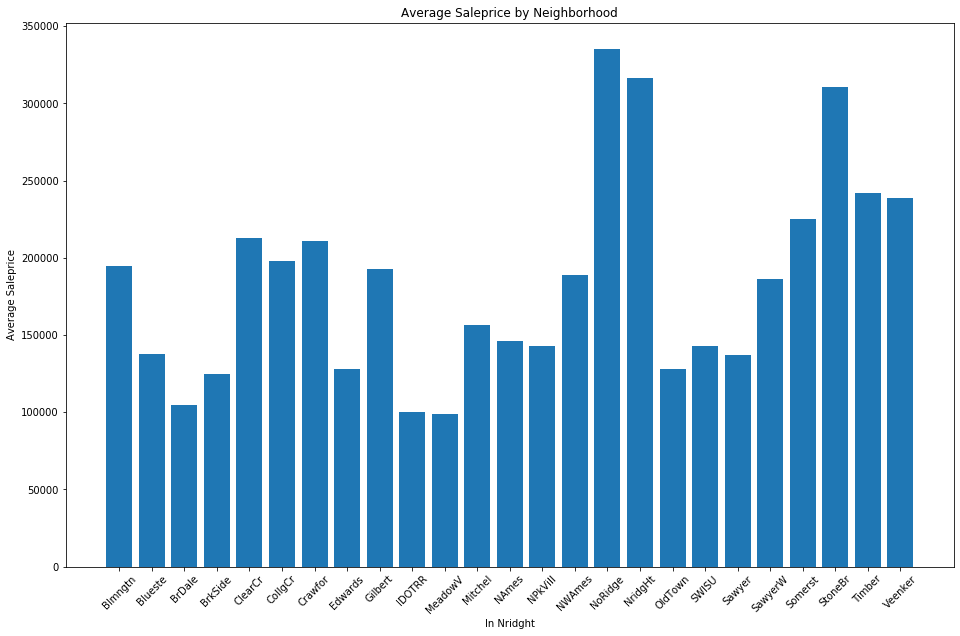

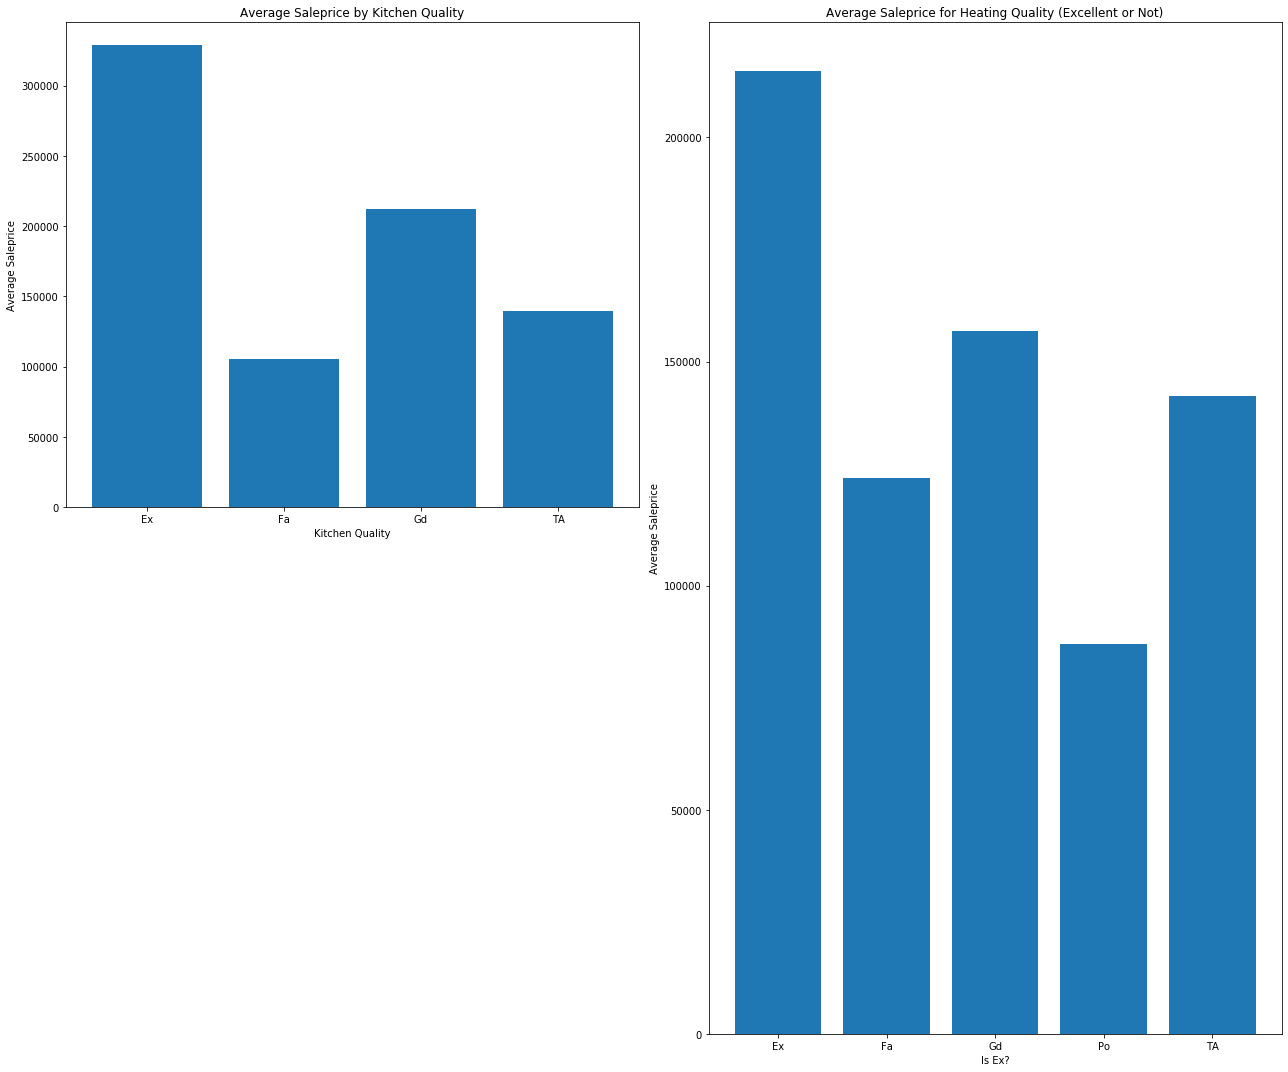

In [171]:
plt.figure(figsize=(35,10))
plt.subplot(1,2,1)
plt.bar(houseprices.groupby("neighborhood")["saleprice"].mean().index, houseprices.groupby("neighborhood")["saleprice"].mean())
plt.title("Average Saleprice by Neighborhood")
plt.ylabel("Average Saleprice")
plt.xlabel("In Nridght")
plt.xticks(rotation=45)



plt.figure(figsize=(18,15))
plt.subplot(1,2,2)
plt.bar(heatingqc.groupby("heatingqc")["saleprice"].mean().index, heatingqc.groupby("heatingqc")["saleprice"].mean())
plt.title("Average Saleprice for Heating Quality (Excellent or Not)")
plt.ylabel("Average Saleprice")
plt.xlabel("Is Ex?")


plt.subplot(2,2,1)
plt.bar(kitchen_qual.groupby("kitchenqual")["saleprice"].mean().index, kitchen_qual.groupby("kitchenqual")["saleprice"].mean())
plt.title("Average Saleprice by Kitchen Quality")
plt.ylabel("Average Saleprice")
plt.xlabel("Kitchen Quality")




plt.tight_layout()
plt.show()

In [181]:
features = houseprices[['overallqual', 'totalbsmtsf', 'firstflrsf', 'grlivarea', 'garagecars', 'garagearea', 'TA']]
target = houseprices[['saleprice']]
lrm = linear_model.LinearRegression()

lrm.fit(features, target)
np.set_printoptions(suppress=True)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [[ 21546.40301002     23.97600525     11.87818604     42.77378189
   13630.68760231     15.23634803 -14138.50317818]]

Intercept: 
 [-78657.97318539]


In [180]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
features = sm.add_constant(features)

results = sm.OLS(target, features).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     684.2
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:54:57   Log-Likelihood:                -17480.
No. Observations:                1460   AIC:                         3.498e+04
Df Residuals:                    1452   BIC:                         3.502e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.866e+04   6363.496    -12.361      0.000   -9.11e+04   -6.62e+04
overallqual  2.155e+04   1151.028     18.719      0.000    1.93e+04    2.38e+04
totalbsmtsf    23.9760      4.270      5.615      0.000      15.600      32.352
firstflrsf     11.8782      4.978      2.386      0.017       2.114      21.642
grlivarea      42.7738      2.650     16.140      0.000      37.575      47.972
garagecars   1.363e+04   2988.871      4.560      0.000    7767.721    1.95e+04
garagearea     15.2363     10.359      1.471      0.142      -5.083      35.556
TA          -1.414e+04   2428.049     -5.823      0.000   -1.89e+04   -9375.645
==============================================================================
Omnibus:                      424.726   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41764.504
Skew:                          -0.216   Prob(JB):                         0.00
Kurtosis:                      29.198   Cond. No.                     1.54e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I'm getting a warning that I may have some multicolinearity. When I look at the correlation matrix for the features, I see there's a strong correlation between totalbsmtsf and firstflsf. I'm going to remove firstflrsf as totalbsmtsf has a higher correlation with saleprice and see if that helps. Additionally, I'm going to combine garagearea and garagecars.

In [174]:
features_price = houseprices[['overallqual', 'totalbsmtsf', 'firstflrsf', 'grlivarea', 'garagecars', 'garagearea', 'TA', 'saleprice']]
features_price.corr()

,overallqual,totalbsmtsf,firstflrsf,grlivarea,garagecars,garagearea,TA,saleprice
overallqual,1.000000,0.537808,0.476224,0.593007,0.600671,0.562022,-0.553891,0.790982
totalbsmtsf,0.537808,1.000000,0.819530,0.454868,0.434585,0.486665,-0.311190,0.613581
firstflrsf,0.476224,0.819530,1.000000,0.566024,0.439317,0.489782,-0.273566,0.605852
grlivarea,0.593007,0.454868,0.566024,1.000000,0.467247,0.468997,-0.350179,0.708624
garagecars,0.600671,0.434585,0.439317,0.467247,1.000000,0.882475,-0.399449,0.640409
garagearea,0.562022,0.486665,0.489782,0.468997,0.882475,1.000000,-0.370935,0.623431
TA,-0.553891,-0.311190,-0.273566,-0.350179,-0.399449,-0.370935,1.000000,-0.519298
saleprice,0.790982,0.613581,0.605852,0.708624,0.640409,0.623431,-0.519298,1.000000


In [186]:
houseprices['garage_cars_area'] = houseprices['garagecars'] + houseprices['garagearea']
features = houseprices[['overallqual', 'totalbsmtsf', 'garage_cars_area', 'TA']]
target = houseprices[['saleprice']]
lrm = linear_model.LinearRegression()

lrm.fit(features, target)
np.set_printoptions(suppress=True)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [[ 29487.69645217     38.41360054     72.64587937 -15272.27732658]]

Intercept: 
 [-66353.21920724]


In [187]:
# We need to manually add a constant
# in statsmodels' sm
features = sm.add_constant(features)

results = sm.OLS(target, features).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     884.0
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:04:10   Log-Likelihood:                -17644.
No. Observations:                1460   AIC:                         3.530e+04
Df Residuals:                    1455   BIC:                         3.532e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -6.635e+04   6898.008     -9.619      0.000   -7.99e+04   -5.28e+04
overallqual       2.949e+04   1167.321     25.261      0.000    2.72e+04    3.18e+04
totalbsmtsf         38.4136      3.153     12.185      0.000      32.230      44.598
garage_cars_area    72.6459      6.599     11.009      0.000      59.702      85.590
TA               -1.527e+04   2710.628     -5.634      0.000   -2.06e+04   -9955.121
==============================================================================
Omnibus:                      582.328   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17618.713
Skew:                           1.230   Prob(JB):                         0.00
Kurtosis:                      19.840   Cond. No.                     7.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

These changes significantly helped our multicollinearity problem, but it's clearly still an issue.

I could spend hours looking into new features and changing my model, but I think I understand the process. If I should continue playing with the data or change/add something, please let me know!